In [0]:
# author: Amine Abboudi
# importing requirements

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# function to sample var values from a probability distribution
'''
    low: can be used as lower bound if dist=='unif' or first-order moment o.w.
    high: can be used as upper bound if dist=='unif' or second-order moment o.w.
'''

def sample_var(low=0., high=.5, dist='unif', n=1, seed=42):
    if dist=='unif':
        return np.random.uniform(low,high,n)
    if dist=='norm':
        return np.random.normal(low, high, n)
    else:
        return None
    
sample_var(dist='norm')

array([-0.05782414])

In [0]:
# function that returns the population from a dataframe by year
def get_population(X, year=2050):
    return int(X['population_'+str(year)].sum())

# function that returns the total production from a dataframe by year
def get_production(X, year=2050):
    return X['calories_'+str(year)].sum()

# function that calculates the caloric sufficiency. it is fed by a dataframe [to preserve generality]
def cal_suff(X, year=2050, food_waste=.19, diet=.19, feed_food_factor=2.3, pop_fact=1., ADER=2320*1e3*365.25):
    
    
    conso = 1-food_waste
    ratio = 1 + .52/.29
    perc_feed = conso / ratio
    perc_food = perc_feed * (ratio-1)
    
    prod = get_production(X, year=year)
    food = perc_food * prod
    feed_now_food = 0.
    LS = (1.1483e15*1e3) * get_population(X, year=2000) / 5976296907
    if year==2050:
        LS_2000 = LS
        LS = diet * (food + feed_food_factor * LS_2000) / (1 + diet * (feed_food_factor - 1))
        feed_now_food = feed_food_factor * (LS_2000 - LS)
    
    production = food + LS + feed_now_food
    demand = get_population(X, year) * pop_fact * ADER
    
    return production/demand


data_path = 'outputs/compare/'
df = pd.read_csv(data_path+'ssp1_compare_new.csv')

cal_suff(df, year=2000)

1.9568954104391354

In [0]:
# function that generates samples, calculates cal_suf for parametric variables ['food_waste', 'diet', 'feed_food_factor', 'pop_fact']
# returns  tuples of (sample, cal_suf)
# discriminates by year, ssp and country if need be

def sensitivity(var='food_waste', ssp=1, year=2050, country=None, **kwargs):
    
    data_path = 'outputs/compare/'
    df_ssp = pd.read_csv(data_path+'ssp'+str(ssp)+'_compare_new.csv')
    
    if country:
        df_ssp = df_ssp[df_ssp['ISO3']==country]

    sample = sample_var(**kwargs)
    
    if var=='food_waste':
        sufficiency = cal_suff(df_ssp, year, food_waste=sample)
        
    if var=='diet':
        sufficiency = cal_suff(df_ssp, year, diet=sample)
        
    if var=='feed_food_factor':
        sufficiency = cal_suff(df_ssp, year, feed_food_factor=sample)
    
    if var=='pop_fact':
        sufficiency = cal_suff(df_ssp, year, pop_fact=sample)
        
    return sample, sufficiency

sensitivity(var='diet', ssp=5, country='MAR', n=1, dist='unif')

(array([0.21783426]), array([0.91193113]))

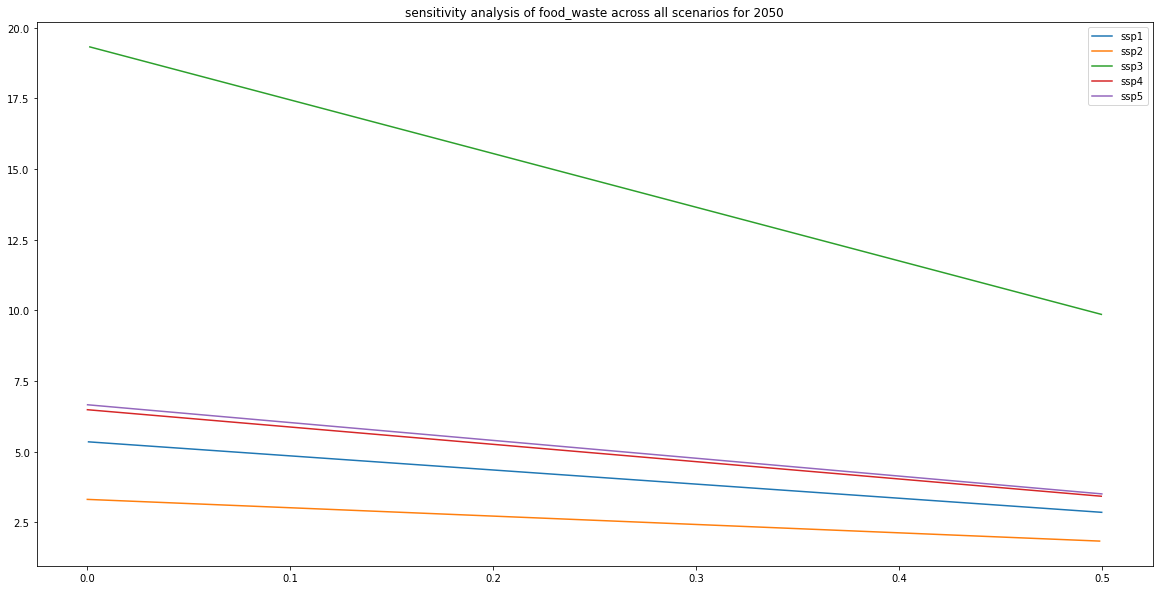

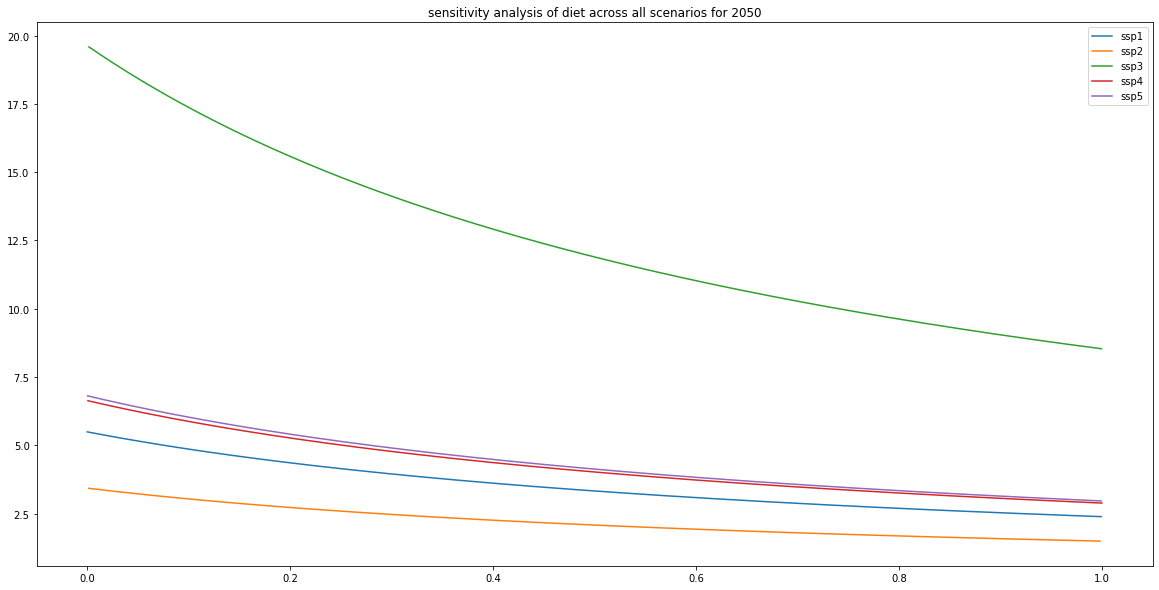

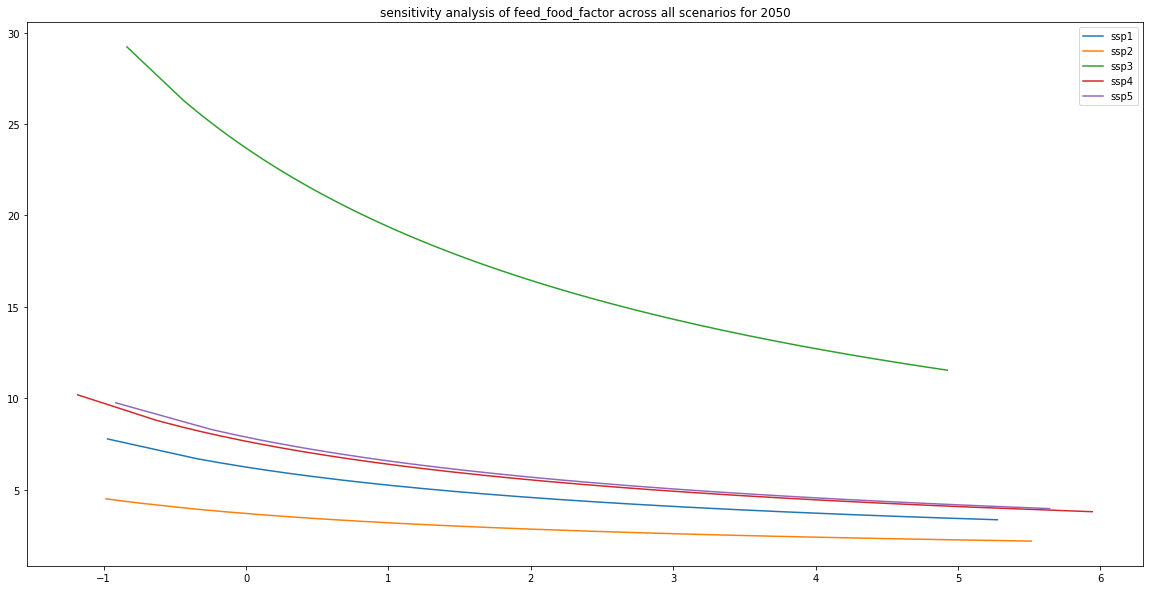

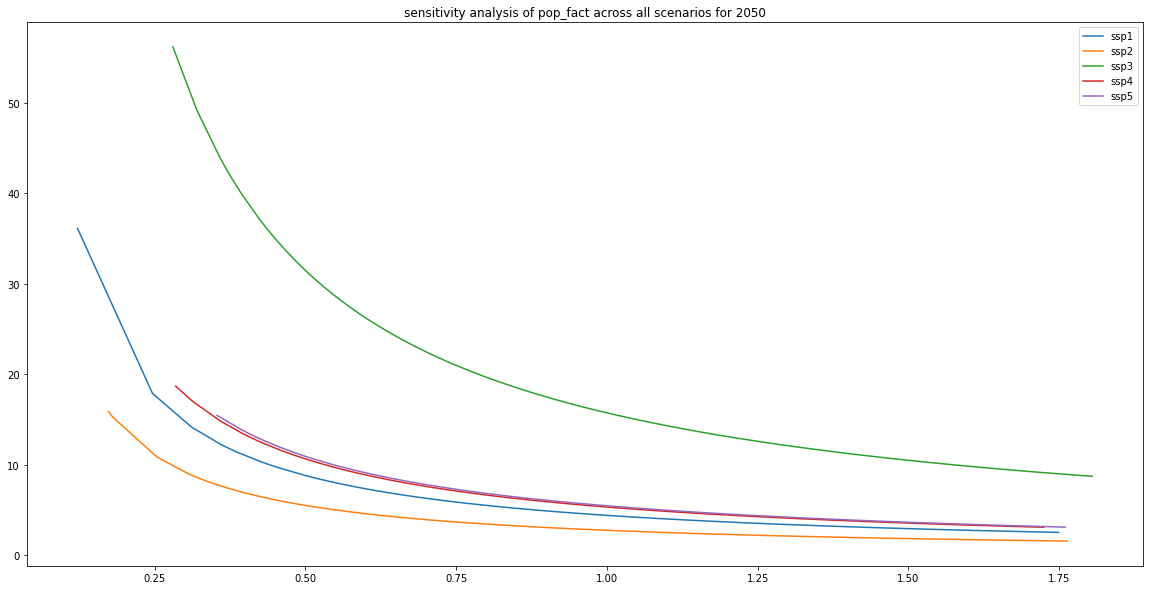

In [0]:
params = ['food_waste', 'diet', 'feed_food_factor', 'pop_fact']
lows = [0., 0., 2.3, 1.]
highs = [.5, 1., 1., .25]
dists = ['unif', 'unif', 'norm', 'norm']
year=2050

for param, low, high, dist in zip(params, lows, highs, dists):
    plt.figure(figsize=(20,10))
    
    for i in range(5):
        x, y = sensitivity(var=param, ssp=i+1, year=year, country='BWA',n=1000, dist=dist, low=low, high=high)

        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
        plt.plot(x, y, label='ssp'+str(i+1))
        plt.legend()

    plt.title('sensitivity analysis of '+param+' across all scenarios for '+str(year))
    plt.show()

In [0]:
# function that generates samples, calculates cal_suf for predicted values ['cropland', 'yield']
# returns  tuples of (sample, cal_suf)
# discriminates by year, ssp and country if need be

def sensitivity_2(var='cropland', ssp=1, year=2050, country=None, **kwargs):
    var_dict = {'cropland': '%cropland_2050', 'yield':'cal_per_ha_pred'}
    sufficiency = []
    
    data_path = 'outputs/compare/'
    df_ssp = pd.read_csv(data_path+'ssp'+str(ssp)+'_compare_new.csv')
    
    if country:
        df_ssp = df_ssp[df_ssp['ISO3']==country]
        
    df_dup = df_ssp.copy()
    sample = sample_var(**kwargs)
    
    for smp in list(sample):
        df_dup[var_dict[var]] = df_ssp[var_dict[var]]*smp
        df_dup['calories_2050'] = df_dup['%cropland_2050'] * df_dup['cal_per_ha_pred'] * df_dup['ha_per_pixel']
        sufficiency.append(cal_suff(df_dup))
        
    return sample * df_ssp[var_dict[var]].mean(), np.array(sufficiency)

sensitivity_2(var='yield', ssp=5, country='USA', n=1, low=1., high=.02, dist='norm')

(array([8.80661387e+09]), array([2.01153905]))

<Figure size 1440x720 with 0 Axes>

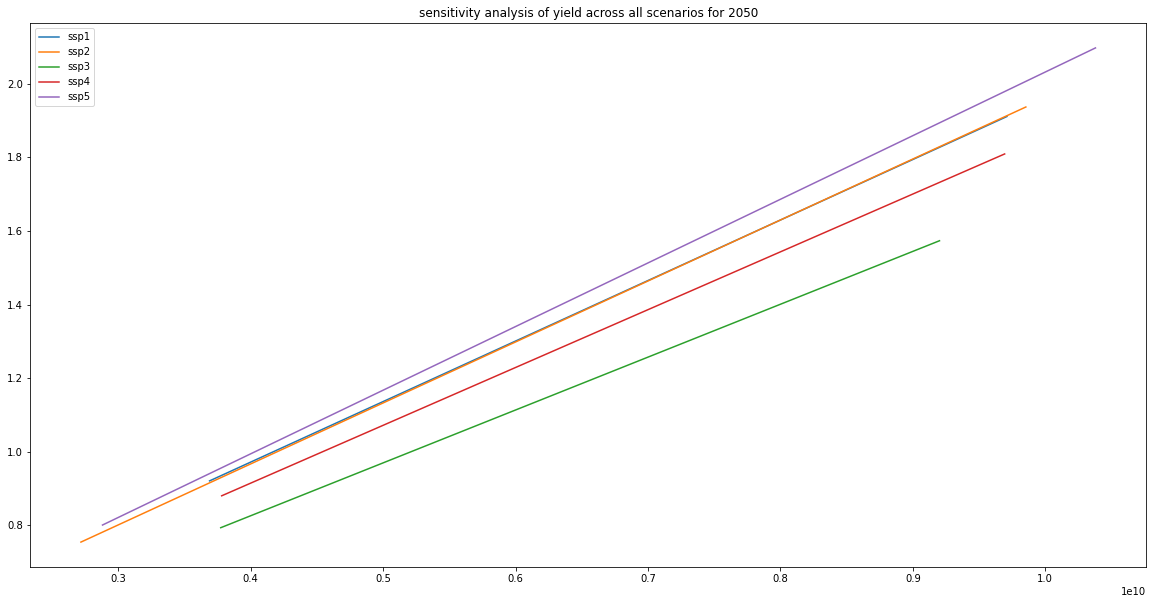

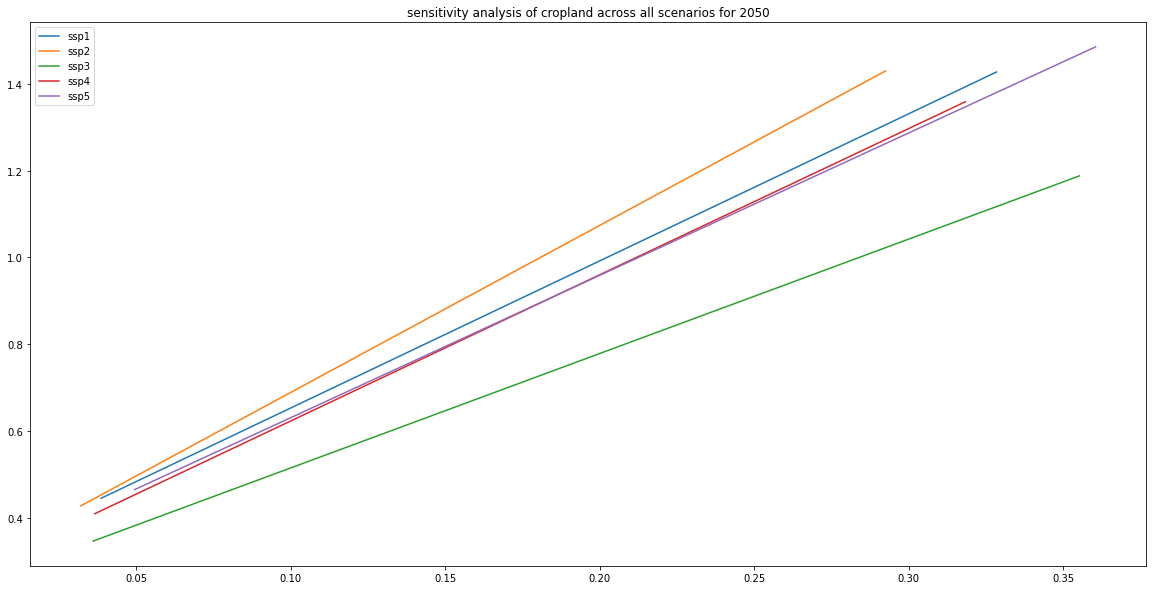

In [0]:
plt.figure(figsize=(20,10))

params = ['yield', 'cropland']
lows = [1., 1.]
highs = [.2, .1]
dists = ['norm', 'unif']
year=2050

for param, low, high, dist in zip(params, lows, highs, dists):
    plt.figure(figsize=(20,10))
    for i in range(5):
        x, y = sensitivity_2(var=param, ssp=i+1,n=100, dist=dist, low=low, high=high)

        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
        plt.plot(x, y, label='ssp'+str(i+1))
        plt.legend()
    
    plt.title('sensitivity analysis of '+param+' across all scenarios for '+str(year))
    plt.show()

In [0]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [0]:
float(0.3)==float(0.1)+float(0.1)+float(.1)

False

In [0]:
a= float(0.1)

In [0]:
format(a, '0.25f')

'0.1250000000000000000000000'

In [0]:
from fractions import Fraction

Fraction(a)

Fraction(3602879701896397, 36028797018963968)